In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
# set path to project directory
root_dir = Path.cwd().parents[1]
if not root_dir in sys.path:
    sys.path.insert(0, str(root_dir))

from placefield_dynamics.orientation_detection.HierarchicalBayesModel.NestedSamplingMethods import (
    run_sampling,
)
from placefield_dynamics.placefield_detection.utils import load_data
from placefield_dynamics.placefield_detection.utils import (
    gauss_smooth,
)

from placefield_dynamics.orientation_detection.HierarchicalBayesInference import (
    HierarchicalBayesInference,
)
from placefield_dynamics.orientation_detection.utils import elliptical_pdf, softplus


import numpy as np
from scipy.special import factorial as sp_factorial

from matplotlib import pyplot as plt

# from ipywidgets import interact
import itertools



# %matplotlib widget

In [2]:
folderPath = Path("../../../data/Subhodeep/ID20/20230913/")
stimulusPath = folderPath / "ID20_1_230913.1_ipsi_stimProtocol_191.mat"
# stimulusPath = folderPath / "ID20_1_230913.1_bino_stimProtocol_1820.mat"
# stimulusPath = folderPath / "ID20_1_230913.1_cont_stimProtocol_1840.mat"
caimanPath = folderPath / "results_CaImAn_20230913_20_00003_align_redetected.mat"

ld = load_data(stimulusPath)
stimulus_data = ld["runInfo"]

meta_data = load_data(folderPath / "CaimanMeta.mat")
f = meta_data["CaimanMeta"]["frame_rate"]

caiman_data = load_data(caimanPath)
stimulus_data["frame_times"] = np.arange(caiman_data["C"].shape[1]) / f

In [3]:
from placefield_dynamics.orientation_detection.utils.utils_analysis import (
    calculate_firing_maps,
    get_spikes,
    get_unique_stimulus_values,
)

spikes = get_spikes(caiman_data["S"], f=f)
event_counts, dwelltime = calculate_firing_maps(
    stimulus_data=stimulus_data, spikes=spikes, dt_onset=0.2, dt_response=0.25
)

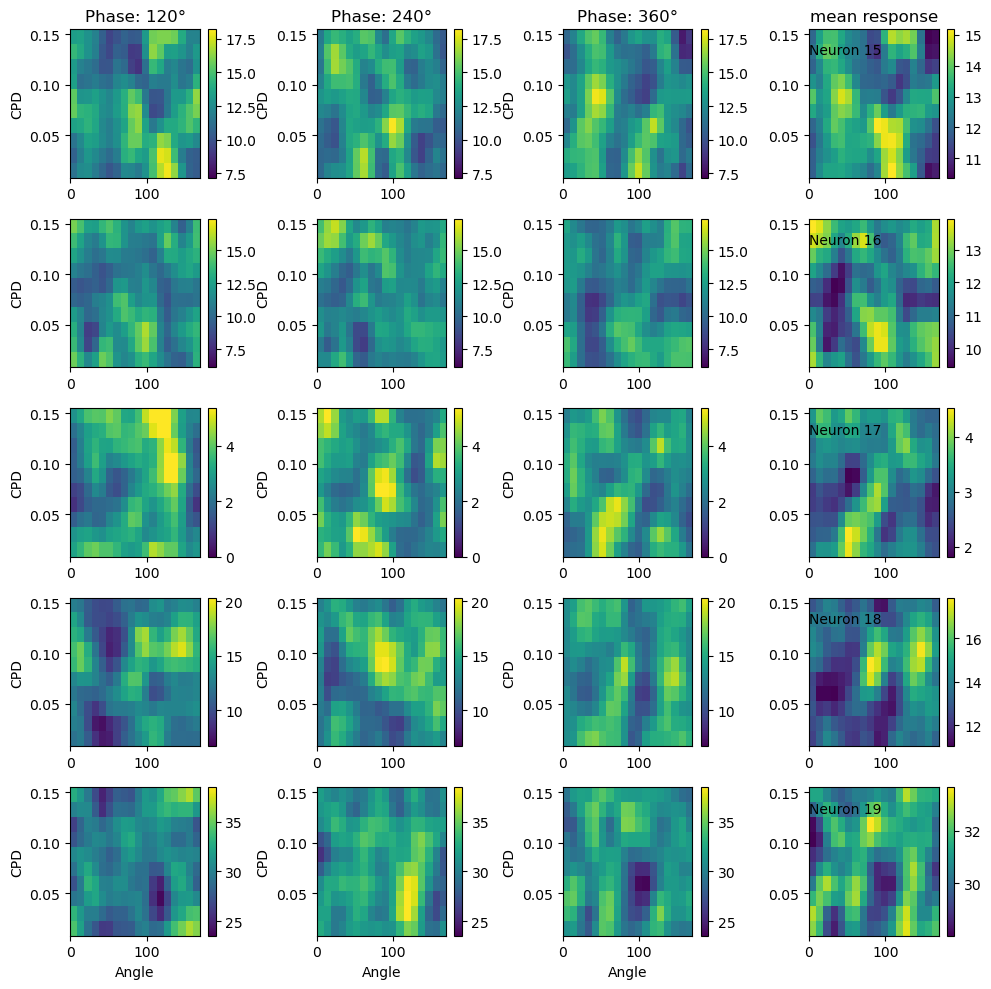

In [4]:
from placefield_dynamics.orientation_detection.utils.utils_display import (
    plot_firing_maps,
)

neurons = range(15, 20)
unique_values = get_unique_stimulus_values(stimulus_data)
plot_firing_maps(
    firing_maps=event_counts / dwelltime[..., np.newaxis],
    neurons=neurons,
    unique_values=unique_values,
)

In [5]:
# neurons 11, 18, 19, ...?

In [6]:
(unique_values["phases"], unique_values["angles"], unique_values["cycles"])

# 1 / (2 * (hbm.X_FoV[0, 1] - hbm.X_FoV[0, 0]))

(array([120, 240, 360], dtype=uint16),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170], dtype=uint8),
 array([0.0079    , 0.01099588, 0.01530497, 0.02130273, 0.0296509 ,
        0.04127058, 0.05744382, 0.07995507, 0.1112881 , 0.1549    ]))

In [ ]:
measure_points = (
    np.deg2rad(unique_values["phases"]),
    np.deg2rad(unique_values["angles"]),
    unique_values["cycles"] * 180 / np.pi,
)
# print(p_random, p_trafo, logp)

In [ ]:
neuron = 19
# fmap = gauss_smooth(firing_maps[..., neuron], (0, 1, 1), mode="wrap")
# fmap = firing_maps[..., neuron]
hbm = HierarchicalBayesInference(logLevel="DEBUG")

hbm.prepare_data(
    event_counts[..., neuron],
    dwelltime,
    measure_points,
    [np.deg2rad(140), np.deg2rad(114)],
    FoV_steps=101,
)
hbm.set_priors()
# sampler, results = hbm.run_sampling(show_status=True, n_live=400)

set FoV
set gratings


In [8]:
my_trafo = hbm.set_prior_transform(vectorized=False)
my_logp = hbm.set_logp_func(vectorized=False)

p_random = np.random.rand(hbm.n_params)
p_trafo = my_trafo(p_random)
logp = my_logp(p_trafo)  # , plot=True)

DEBUG:nestLogger:time for transforming parameters: 21.70
DEBUG:nestLogger:time for calculating gabor filter: 537.87
DEBUG:nestLogger:time for calculating model firing rate: 2502.68
DEBUG:nestLogger:time for applying nonlinearity: 233.89
DEBUG:nestLogger:time for calculating log probability of spike observation: 114.20


Text(0, 0.5, 'Output')

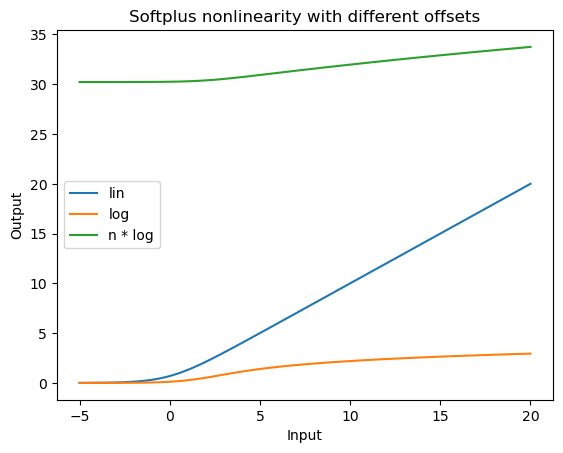

In [10]:
x = np.linspace(-5, 20, 100)
y1 = softplus(x, alpha=1.0, gamma=0.0, delta=0.0)
y2 = np.log(softplus(x, alpha=1.0, gamma=2.0, delta=1.0))
y3 = 8.5 * np.log(softplus(x, alpha=1.0, gamma=2.0, delta=35.0))

plt.figure()
plt.plot(x, y1, label="lin")
plt.plot(x, y2, label="log")
plt.plot(x, y3, label="n * log")
plt.legend()
plt.title("Softplus nonlinearity with different offsets")
plt.xlabel("Input")
plt.ylabel("Output")

set FoV
set gratings


671it [00:19, 34.63it/s, +100 | bound: 15 | nc: 1 | ncall: 22253 | eff(%):  3.480 | loglstar:   -inf < -2598.959 <    inf | logz: -2605.943 +/-  0.239 | dlogz:  0.013 >  1.000]


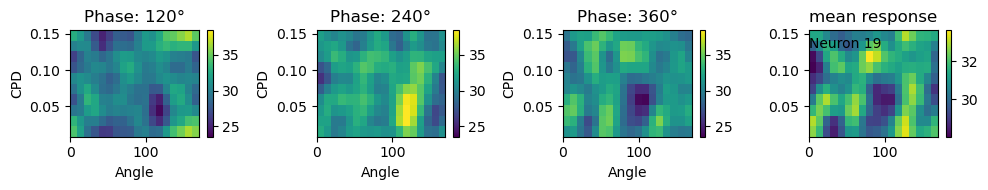

In [11]:
neuron = 19
plot_firing_maps(
    firing_maps=event_counts / dwelltime[..., np.newaxis],
    neurons=[neuron],
    unique_values=unique_values,
)
hbm = HierarchicalBayesInference()

hbm.prepare_data(
    event_counts[..., neuron],
    dwelltime,
    measure_points,
    [np.deg2rad(140), np.deg2rad(114)],
)
hbm.set_priors()
my_trafo = hbm.set_prior_transform(vectorized=False)
my_logp = hbm.set_logp_func(vectorized=False)

results, sampler = run_sampling(
    my_trafo,
    my_logp,
    hbm.parameter_names_all,
    hbm.periodic,
    show_status=True,
    n_live=100,
    nP=12,
)

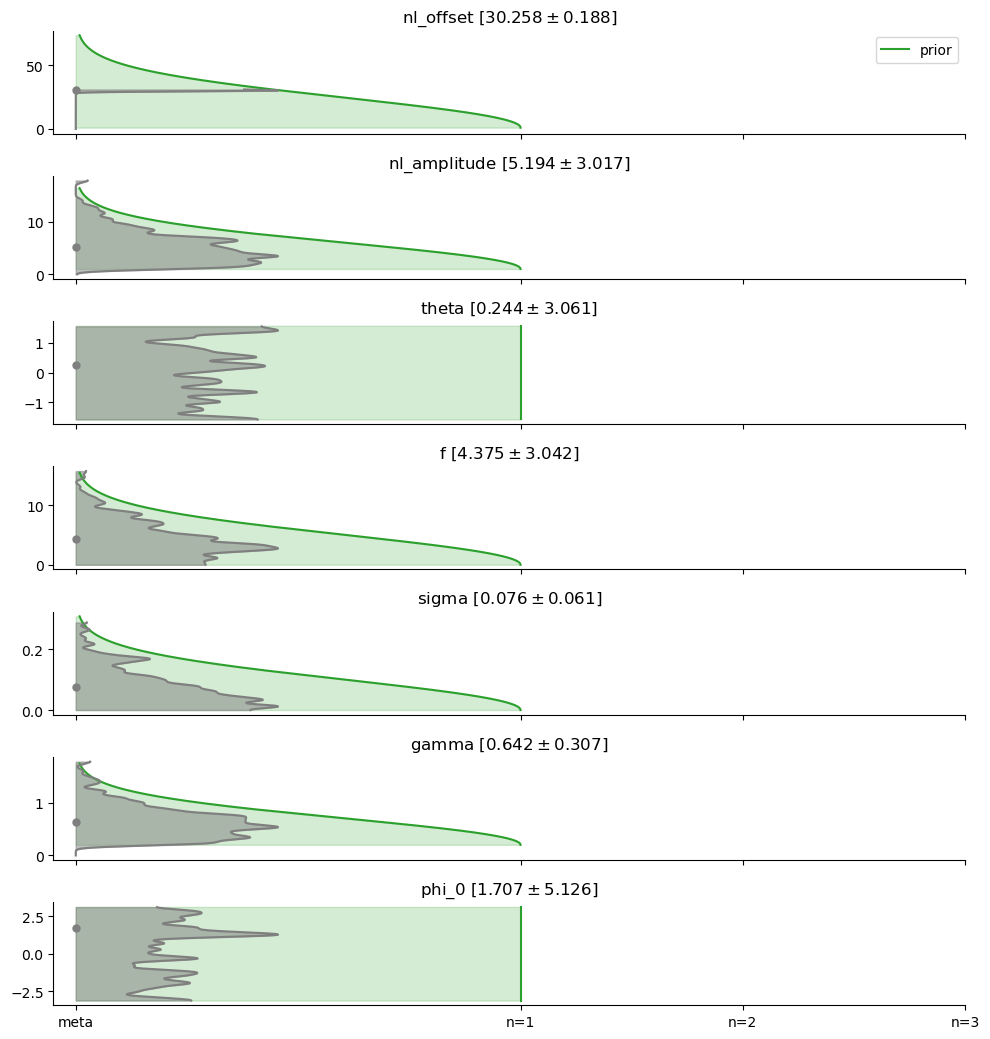

In [12]:
from placefield_dynamics.orientation_detection.HierarchicalBayesModel.NestedSamplingMethods import (
    plot_results,
)

plot_results(hbm, results)

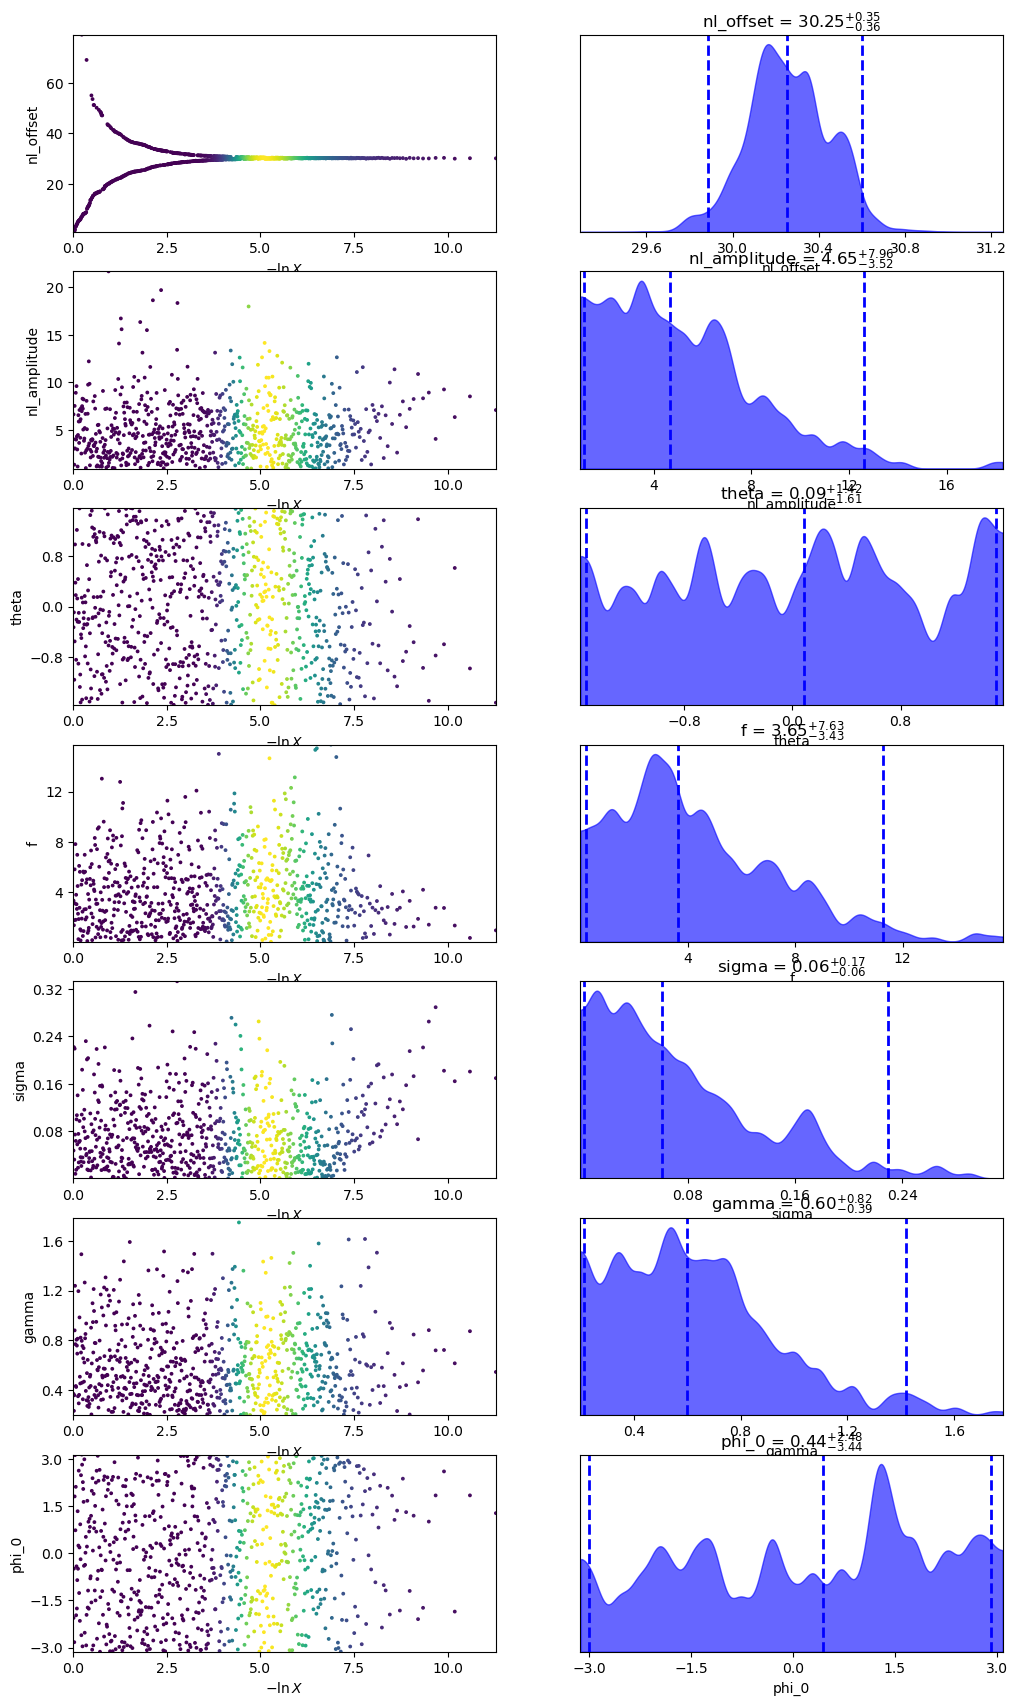

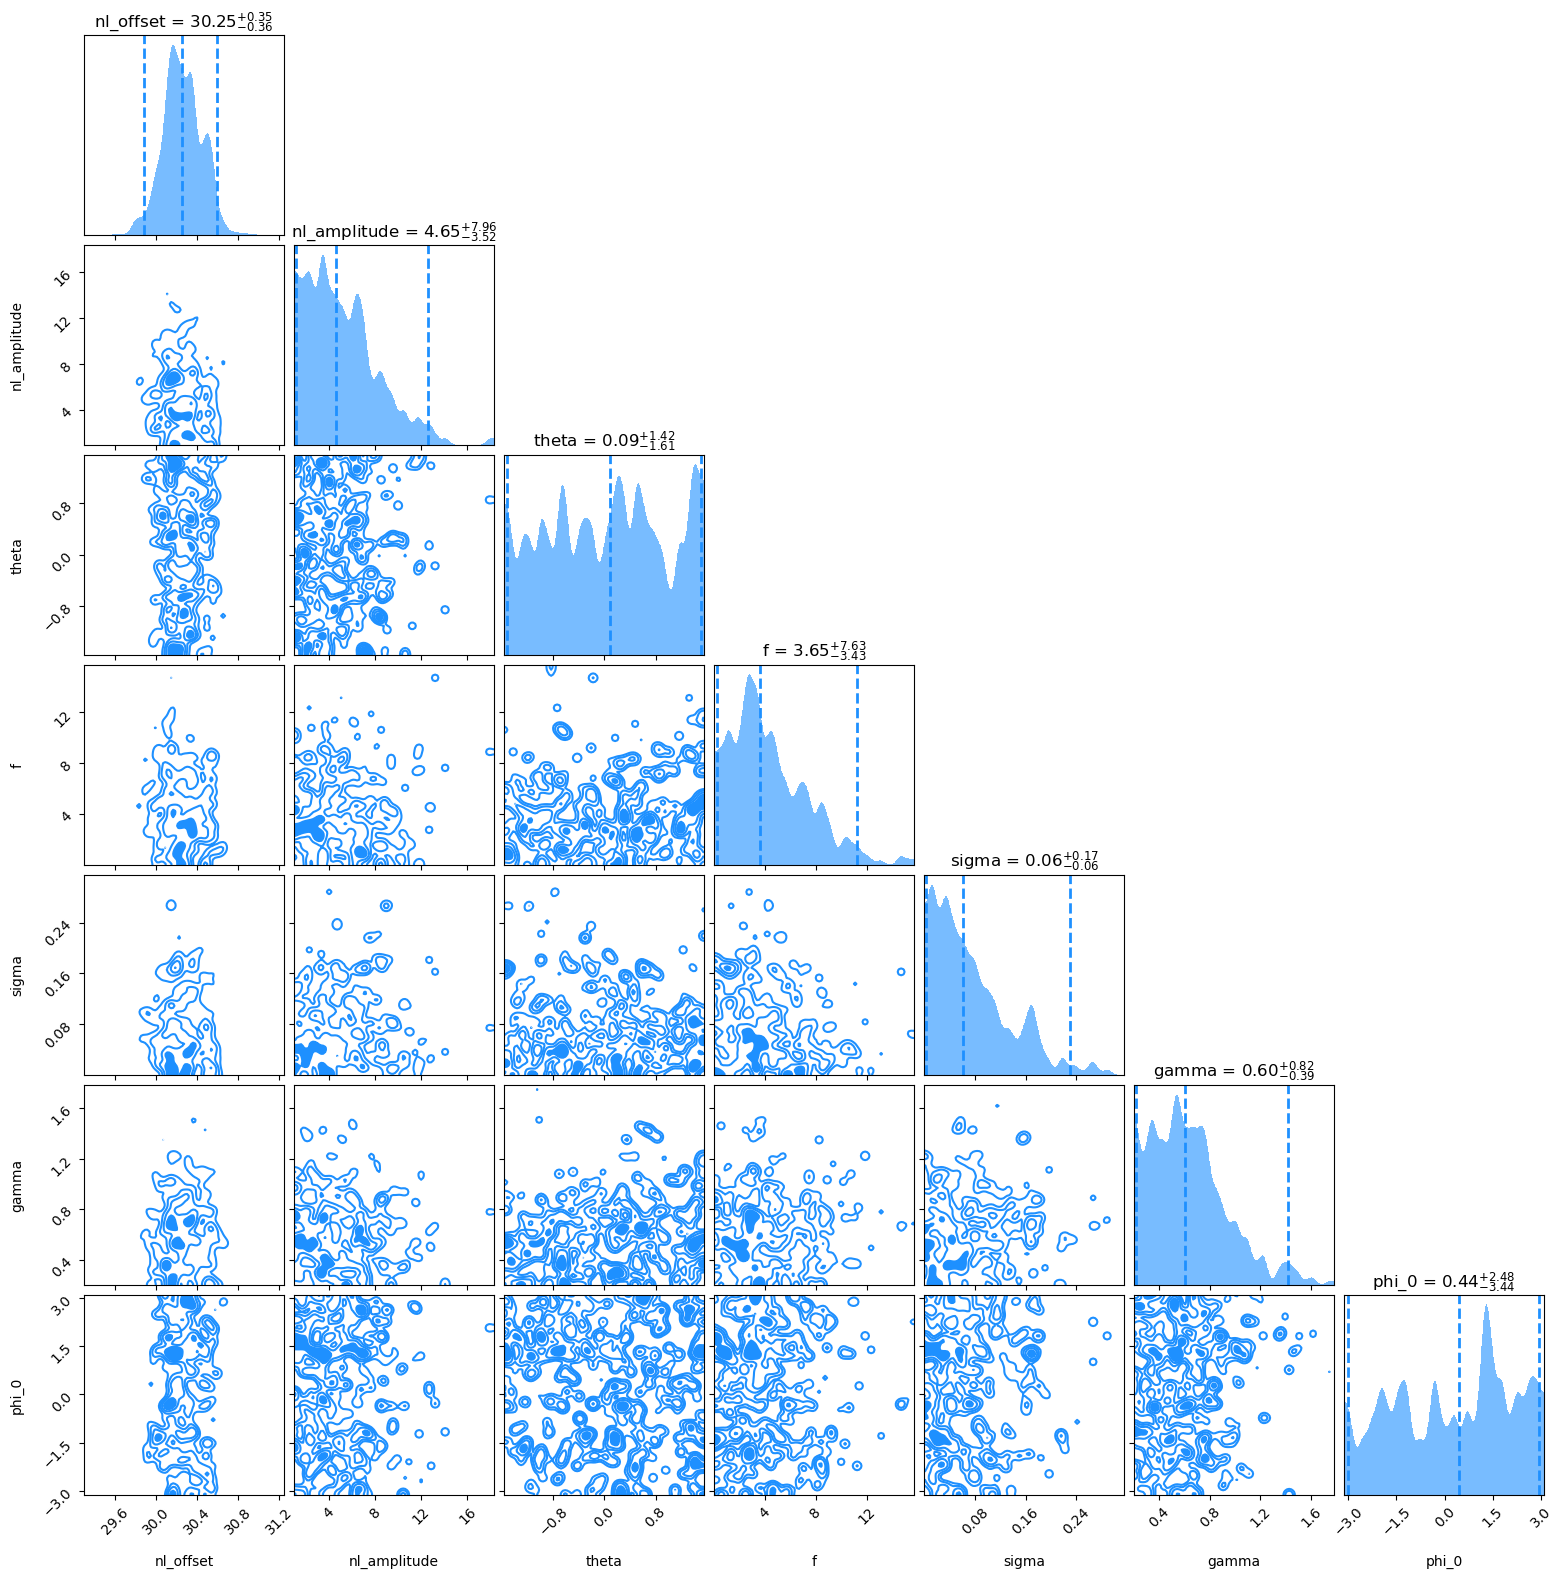

In [13]:
# %matplotlib widget
from dynesty import plotting as dyplot

dyplot.traceplot(
    results,
    show_titles=True,
    labels=hbm.parameter_names_all,
    trace_cmap="viridis",
)
plt.show(block=False)

dyplot.cornerplot(
    sampler.results,
    show_titles=True,
    color="dodgerblue",
    labels=hbm.parameter_names_all,
)
plt.show(block=False)

set FoV
set gratings
PLOT PROBABILITY OVER COMPLETE PHASE SPACE


[np.float64(30.258317160575505),
 np.float64(5.194010081446713),
 np.float64(0.02552839094295033),
 np.float64(4.374821749967453),
 np.float64(0.07630800545605822),
 np.float64(0.6420853844312915),
 np.float64(0.22540746877090365)]

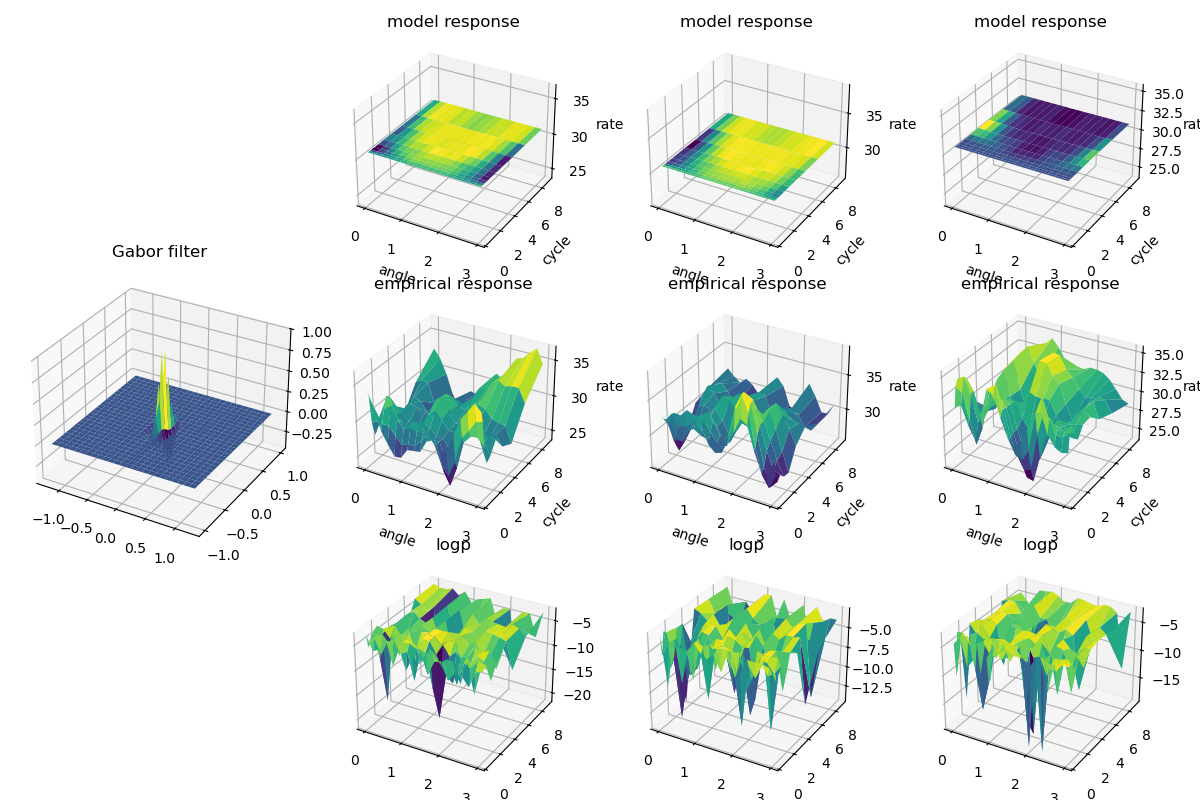

In [15]:
from HierarchicalBayesModel.NestedSamplingMethods import (
    get_samples_from_results,
    get_posterior_from_samples,
)
%matplotlib widget

samples = get_samples_from_results(results, mode="dynesty")
posterior = get_posterior_from_samples(
    samples["samples"],
    samples["weights"],
    hbm.parameter_names_all,
    # x={
    #     "gamma": np.linspace(1, 3, 101),
    #     "delta": np.linspace(1, 8, 101),
    #     "nu_max": np.linspace(0, 100, 101),
    # },
)
mean_list = [post["mean"] for post in posterior.values()]
mean_list

mean_dict = {key: post["mean"] for key, post in posterior.items()}
mean_dict
# posterior
# mean_list[-1] = 0
steps = 51
hbm.set_FoV(FoV_range=[np.deg2rad(140), np.deg2rad(114)], FoV_steps=steps)
hbm.set_gratings(FoV_steps=steps)
my_logp = hbm.set_logp_func(vectorized=False,coding="simple")
my_logp(np.array(mean_list), plot=True)
mean_list

# complex gabor model for some reason does not give complete phase independence

In [50]:
hbm.prepare_data(
    event_counts[..., neuron],
    dwelltime,
    (
        np.deg2rad(unique_values["phases"]),
        np.deg2rad(unique_values["angles"]),
        unique_values["cycles"] * 180 / np.pi,
    ),
    [np.deg2rad(140), np.deg2rad(114)],
    FoV_steps=51,
)

set FoV
set gratings
(np.float32(2.0943952), np.float16(0.0), np.float64(0.45263665815335036))
(np.float32(2.0943952), np.float16(0.0), np.float64(0.6300172296228589))
(np.float32(2.0943952), np.float16(0.0), np.float64(0.8769102158915014))
(np.float32(2.0943952), np.float16(0.0), np.float64(1.2205563444593437))
(np.float32(2.0943952), np.float16(0.0), np.float64(1.698871518431804))
(np.float32(2.0943952), np.float16(0.0), np.float64(2.3646302354171413))
(np.float32(2.0943952), np.float16(0.0), np.float64(3.2912884168017085))
(np.float32(2.0943952), np.float16(0.0), np.float64(4.581088104315018))
(np.float32(2.0943952), np.float16(0.0), np.float64(6.376338248681946))
(np.float32(2.0943952), np.float16(0.0), np.float64(8.875116246576454))
(np.float32(2.0943952), np.float16(0.1746), np.float64(0.45263665815335036))
(np.float32(2.0943952), np.float16(0.1746), np.float64(0.6300172296228589))
(np.float32(2.0943952), np.float16(0.1746), np.float64(0.8769102158915014))
(np.float32(2.0943952),

In [34]:
80 / 180 * np.pi

1.3962634015954636

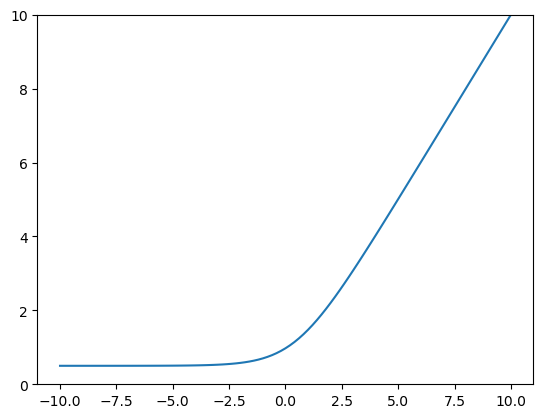

In [ ]:
x = np.linspace(-10, 10, 101)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, softplus(x, 1.0, 0.5, 0.5))
plt.setp(ax, ylim=(0, 10))
plt.show()

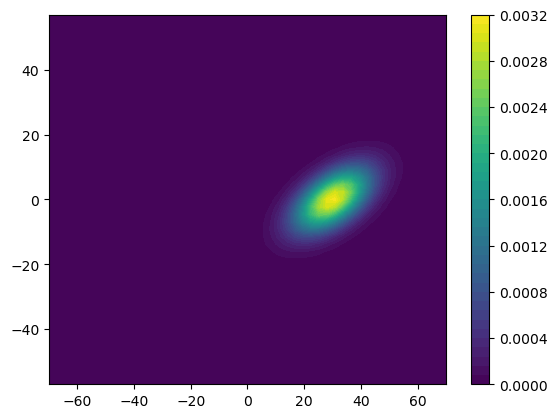

In [ ]:
X = hbm.X_FoV
Y = hbm.Y_FoV

ellipse = elliptical_pdf(X, Y, x0=30, sigma_x=10, sigma_y=5, angle=np.pi / 6)

fig = plt.figure()
ax = fig.add_subplot(111)
h = ax.contourf(X, Y, ellipse, levels=50, cmap="viridis")
plt.colorbar(h)
plt.show(block=False)

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Interactive elliptical_pdf explorer
# Requires: X, Y, elliptical_pdf, plt, np already defined in notebook


# widget definitions
x0_w = widgets.FloatSlider(
    value=30.0, min=float(X.min()), max=float(X.max()), step=0.5, description="x0"
)
y0_w = widgets.FloatSlider(
    value=0.0, min=float(Y.min()), max=float(Y.max()), step=0.5, description="y0"
)
sx_w = widgets.FloatSlider(
    value=10.0, min=0.1, max=100.0, step=0.1, description="sigma_x"
)
sy_w = widgets.FloatSlider(
    value=5.0, min=0.1, max=100.0, step=0.1, description="sigma_y"
)
angle_w = widgets.FloatSlider(
    value=30.0, min=0.0, max=180.0, step=1.0, description="angle (deg)"
)
amp_w = widgets.FloatSlider(
    value=1.0, min=0.0, max=5.0, step=0.01, description="amplitude"
)
levels_w = widgets.IntSlider(value=50, min=5, max=200, step=1, description="levels")
cmap_w = widgets.Dropdown(
    options=["viridis", "plasma", "inferno", "magma", "cividis", "hot"],
    value="viridis",
    description="cmap",
)

out = widgets.Output()


def _update(x0, y0, sigma_x, sigma_y, angle, amplitude, levels, cmap):
    with out:
        clear_output(wait=True)
        ang_rad = np.deg2rad(angle)
        # shift coordinates by x0,y0 then compute elliptical_pdf
        Z = elliptical_pdf(
            X - x0, Y - y0, sigma_x=sigma_x, sigma_y=sigma_y, angle=ang_rad
        )
        Z = Z * amplitude
        fig, ax = plt.subplots(figsize=(6, 5))
        cf = ax.contourf(X, Y, Z, levels=levels, cmap=cmap)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_title(
            f"elliptical_pdf (x0={x0:.1f}, y0={y0:.1f}, sx={sigma_x:.1f}, sy={sigma_y:.1f}, angle={angle:.1f}°)"
        )
        plt.colorbar(cf, ax=ax)
        plt.show()


controls = widgets.VBox(
    [
        widgets.HBox([x0_w, y0_w]),
        widgets.HBox([sx_w, sy_w, angle_w]),
        widgets.HBox([amp_w, levels_w, cmap_w]),
    ]
)

ui = widgets.VBox([controls, out])
display(ui)

# link widgets to update function
widgets.interactive_output(
    _update,
    {
        "x0": x0_w,
        "y0": y0_w,
        "sigma_x": sx_w,
        "sigma_y": sy_w,
        "angle": angle_w,
        "amplitude": amp_w,
        "levels": levels_w,
        "cmap": cmap_w,
    },
)

Output()

In [ ]:
neuron = 19
# fmap = gauss_smooth(firing_maps[..., neuron], (0, 1, 1), mode="wrap")
fmap = firing_maps[..., neuron]
hbm = HierarchicalBayesInference(
    fmap,
    dwelltime[..., neuron],
    (arrays["phases"], arrays["angles"], arrays["cycles"]),
    [140, 114],
)
hbm.set_priors(wrap=["theta", "theta_gauss"])
sampler, results = hbm.run_sampling(show_status=True, n_live=400)

[140, 114]
get gratings
[[ True  True  True  True  True  True  True  True False False False]
 [False False False False False False False False  True  True  True]]


ValueError: need more than 1 value to unpack

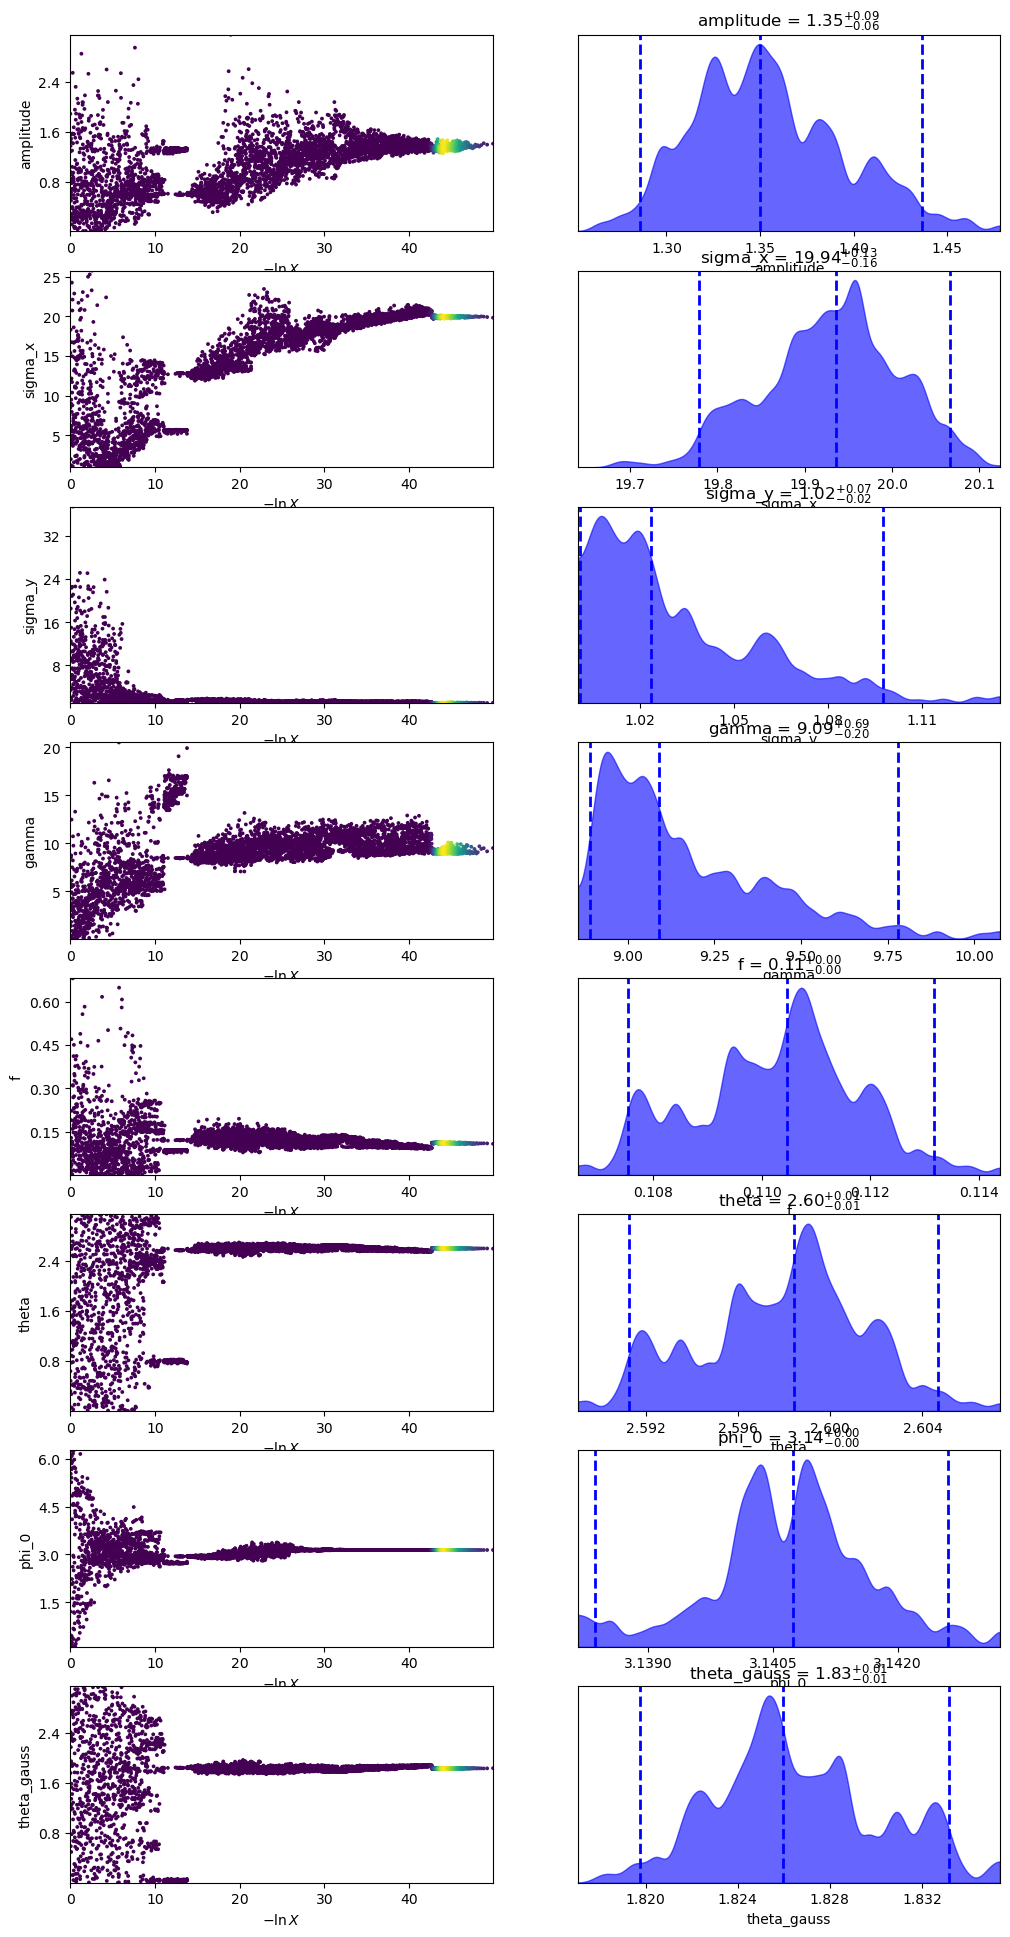

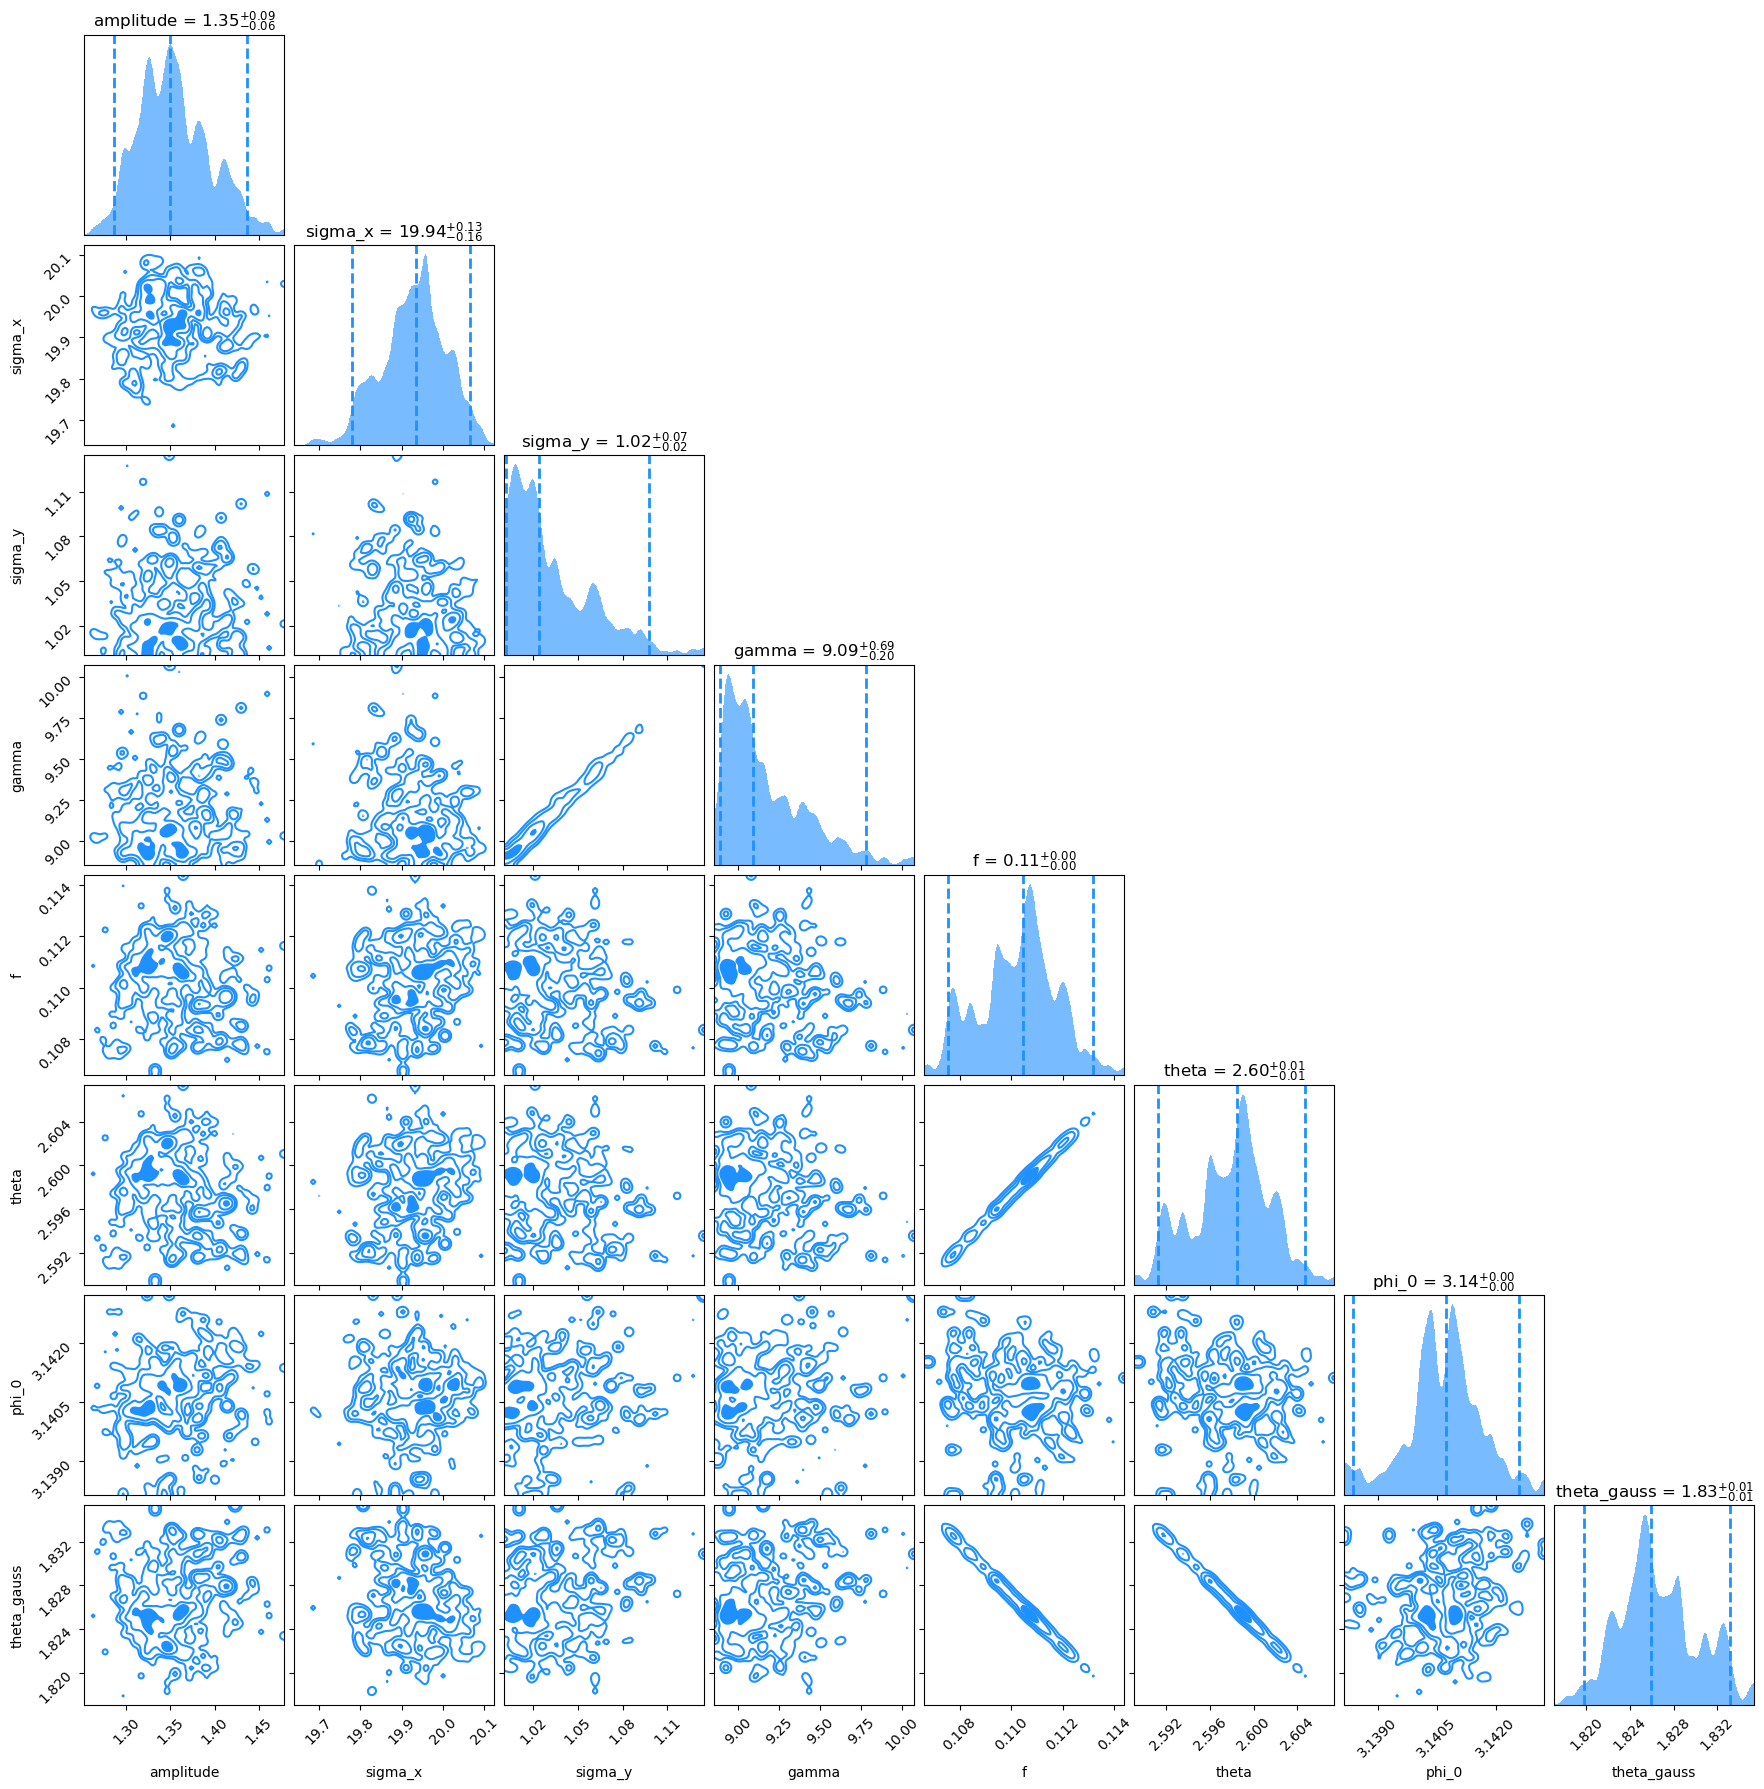

In [92]:
# %matplotlib widget
from dynesty import plotting as dyplot

dyplot.traceplot(
    sampler.results,
    show_titles=True,
    labels=hbm.paramNames,
    trace_cmap="viridis",
)
plt.show(block=False)

dyplot.cornerplot(
    sampler.results,
    show_titles=True,
    color="dodgerblue",
    labels=hbm.paramNames,
)
plt.show(block=False)

In [163]:
mean = {}
mode = "ultranest"
for i, key in enumerate(hbm.paramNames):
    if mode == "dynesty":
        samp = sampler.results.samples[:, i]
        weights = sampler.results.importance_weights()
    else:
        samp = results["weighted_samples"]["points"][:, i]
        weights = results["weighted_samples"]["weights"]
    mean[key] = (samp * weights).sum()
    print(f"{key} mean: {mean[key]}")

amplitude mean: 0.08309734346744291
sigma_x mean: 5.6144058826340135
sigma_y mean: 10.853751544845021
gamma mean: 0.6961662452912125
f mean: 0.17465228425680063
theta mean: 1.5247908710405915
phi_0 mean: 2.440717093165703
theta_gauss mean: 1.2528805823975935
nl_alpha mean: 2.579215279085485


-2.057326987434213
0.0


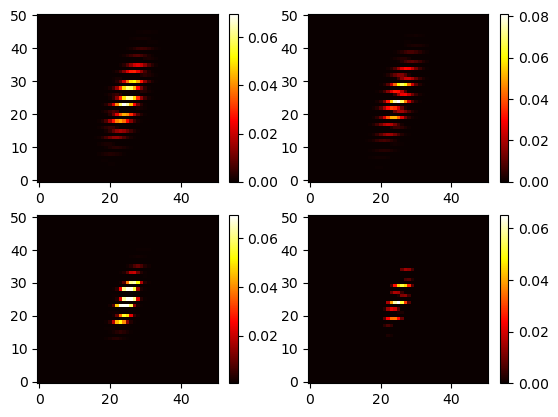

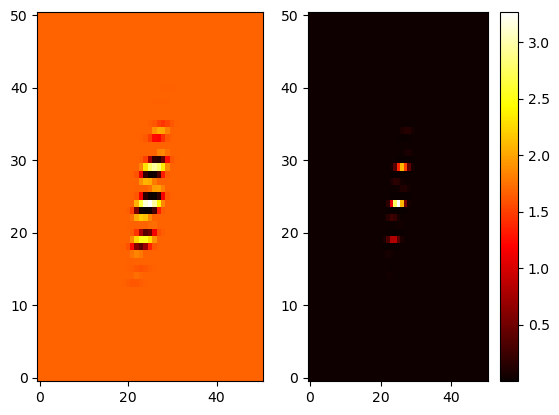

In [290]:
G = hbm.model_of_gabor_filter(mean)[0, ...]

G_inhib = -np.clip(G, -np.inf, 0)
# G_inhib /= G_inhib.max()
G_exc = np.clip(G, 0, np.inf)
# G_exc /= G_exc.max()

fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
img = ax.imshow(G_inhib, cmap="hot", aspect="auto", origin="lower")
plt.colorbar(img)

ax = fig.add_subplot(2, 2, 2)
img = ax.imshow(G_exc, cmap="hot", aspect="auto", origin="lower")
plt.colorbar(img)

from orientation_tuning.HierarchicalBayesInference import softplus, sigmoid, ReLU

input_inhib = sigmoid(G_inhib, G_inhib.max(), G_inhib.max() * 0.1, G_inhib.max() / 2.0)
ax = fig.add_subplot(2, 2, 3)
img = ax.imshow(input_inhib, cmap="hot", aspect="auto", origin="lower")
plt.colorbar(img)

input_exc = ReLU(G_exc, 1.0, 0.0, G_exc.max() * 0.2)
ax = fig.add_subplot(2, 2, 4)
img = ax.imshow(input_exc, cmap="hot", aspect="auto", origin="lower")
plt.colorbar(img)

input = input_exc - input_inhib

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
img = ax.imshow(input, cmap="hot", aspect="auto", origin="lower")

ax = fig.add_subplot(1, 2, 2)
img = ax.imshow(
    softplus(input, 1.0, 0.01, input.max() / 2.0),
    cmap="hot",
    aspect="auto",
    origin="lower",
)
plt.colorbar(img)

print(input.sum())
print(softplus(input.sum(), 1.0, 0.01, input.max() / 2.0))

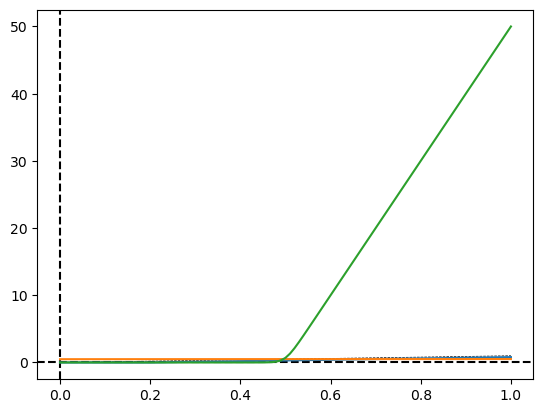

In [ ]:
x = np.linspace(0, 1, 101)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axvline(0, color="k", linestyle="--")
ax.axhline(0, color="k", linestyle="--")
ax.plot(x, x, "k--", linewidth=0.5)

ax.plot(x, ReLU(x, 1, 0.0, 0.2))

ax.plot(x, sigmoid(x, 1, 10.0, 0.5))
ax.plot(x, softplus(x, 1, 0.01, 0.5))

{'amplitude': 0.08309734346744291, 'sigma_x': 5.6144058826340135, 'sigma_y': 10.853751544845021, 'gamma': 0.6961662452912125, 'f': 0.17465228425680063, 'theta': 1.5247908710405915, 'phi_0': 2.440717093165703, 'theta_gauss': 1.2528805823975935, 'nl_alpha': 2.579215279085485}


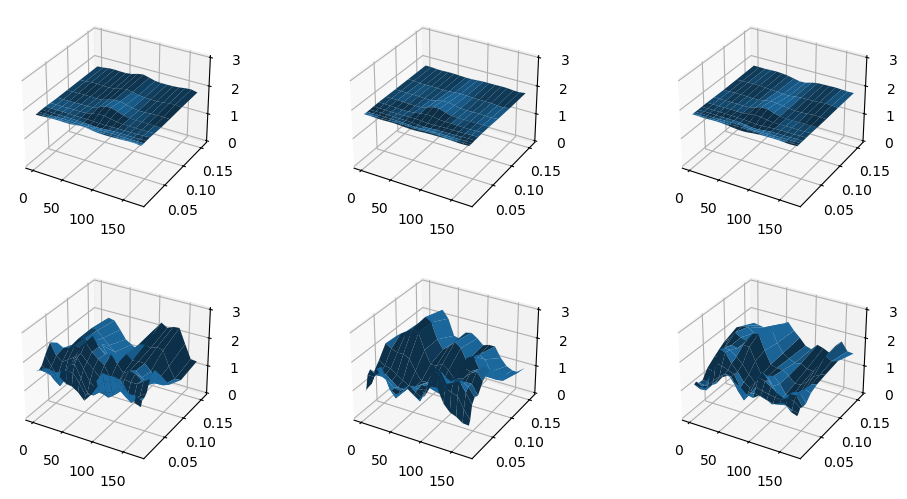

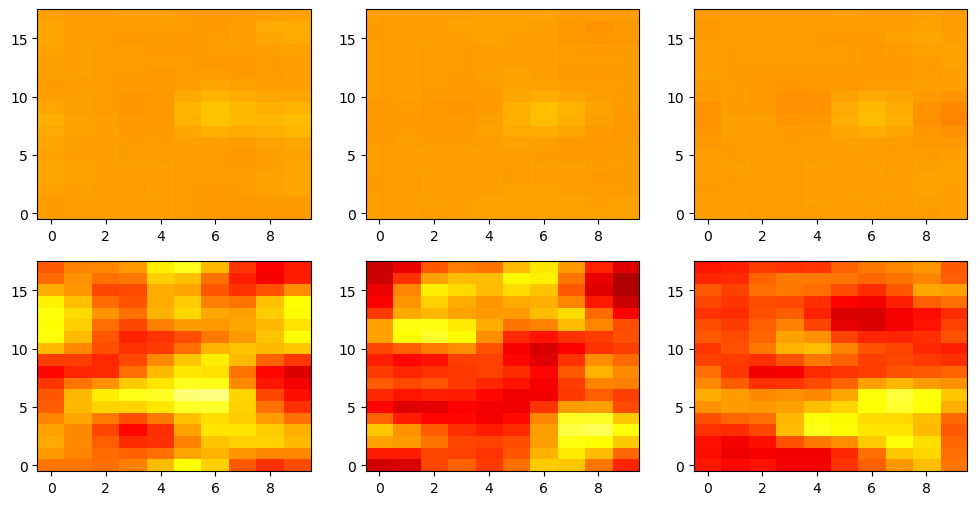

In [ ]:
# %matplotlib widget

# params = {
#     "amplitude": 1.7,
#     "sigma_x": 1.2,
#     "sigma_y": 1.1,
#     "gamma": 2.5,
#     "f": 0.14,
#     "theta": 0.8,
#     "phi_0": 3.16,
#     "theta_gauss": 2.4,
# }

params = {}
print(mean)
for key in params:
    params[key] = np.array([mean[key]])

# G = hbm.model_of_gabor_filter(mean | {"theta": 2.4, "theta_gauss": 0.0})
G = hbm.model_of_gabor_filter(mean)
fmap_model = np.tensordot(G, hbm.gratings, axes=([1, 2], [3, 4]))[0, ...]

X = hbm.grids[1][:, 0, :]
Y = hbm.grids[2][:, 0, :]

fmap_model = gauss_smooth(softplus(fmap_model, 2.6, 0, 0), (0, 1, 1))


fmap = gauss_smooth(firing_maps[..., neuron], (0, 1, 1))


upper_max = 3.0
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(231, projection="3d")
ax1.plot_surface(X, Y, fmap_model[0, ...])
ax2 = fig.add_subplot(232, projection="3d")
ax2.plot_surface(X, Y, fmap_model[1, ...])
ax3 = fig.add_subplot(233, projection="3d")
ax3.plot_surface(X, Y, fmap_model[2, ...])
for axx in [ax1, ax2, ax3]:
    plt.setp(axx, zlim=[0, upper_max])

ax1 = fig.add_subplot(234, projection="3d")
ax1.plot_surface(X, Y, fmap[0, ...])
ax2 = fig.add_subplot(235, projection="3d")
ax2.plot_surface(X, Y, fmap[1, ...])
ax3 = fig.add_subplot(236, projection="3d")
ax3.plot_surface(X, Y, fmap[2, ...])
for axx in [ax1, ax2, ax3]:
    plt.setp(axx, zlim=[0, upper_max])


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(231)
ax1.imshow(
    fmap_model[0, ...],
    cmap="hot",
    aspect="auto",
    origin="lower",
    vmin=0,
    vmax=upper_max,
)
ax2 = fig.add_subplot(232)
ax2.imshow(
    fmap_model[1, ...],
    cmap="hot",
    aspect="auto",
    origin="lower",
    vmin=0,
    vmax=upper_max,
)
ax3 = fig.add_subplot(233)
ax3.imshow(
    fmap_model[2, ...],
    cmap="hot",
    aspect="auto",
    origin="lower",
    vmin=0,
    vmax=upper_max,
)

ax1 = fig.add_subplot(234)
ax1.imshow(
    fmap[0, ...], cmap="hot", aspect="auto", origin="lower", vmin=0, vmax=upper_max
)
ax2 = fig.add_subplot(235)
ax2.imshow(
    fmap[1, ...], cmap="hot", aspect="auto", origin="lower", vmin=0, vmax=upper_max
)
ax3 = fig.add_subplot(236)
ax3.imshow(
    fmap[2, ...], cmap="hot", aspect="auto", origin="lower", vmin=0, vmax=upper_max
)

[140, 114]
get gratings
[[[[-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -7.28807026e-08
    -3.64398469e+01 -1.03899432e+00]
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -2.41291287e+01
    -1.00399915e+01 -4.40396844e+00]
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.58417171e+01
    -3.56030789e+01 -7.43773549e+00]
   ...
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -3.97838271e+00
    -1.01754210e-03 -1.28529583e+01]
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -2.22260654e+01
    -1.54683655e-03 -5.24656777e-04]
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -2.42165409e-04
    -1.05591910e+01 -5.24122117e+00]]

  [[-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -3.62573982e+01
    -7.29726319e+01 -1.49835889e+00]
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -3.51805051e+01
    -4.40967877e+00 -9.70449906e+00]
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -6.14737322e+01
    -1.68811014e+01 -1.

array([-18958.56757407, -24833.12571285, -17270.61894739,  -1406.78294776])

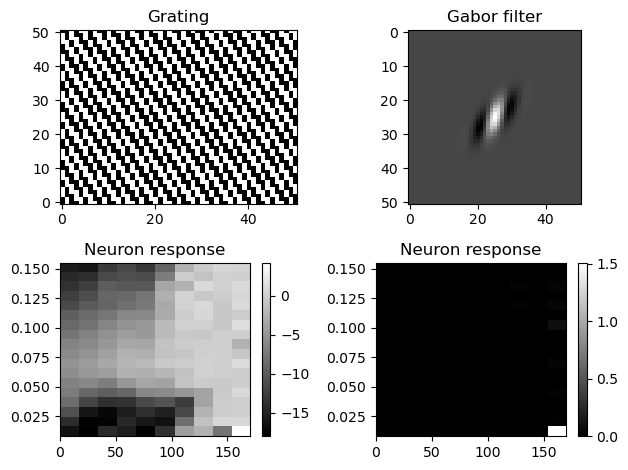

In [302]:
hbm = HierarchicalBayesInference(
    fmap,
    dwelltime[..., neuron],
    (arrays["phases"], arrays["angles"], arrays["cycles"]),
    [140, 114],
)
hbm.set_priors(wrap=["theta", "theta_gauss"])

my_prior_trafo = hbm.set_prior_transform(vectorized=True)
my_logp = hbm.set_logp_func(vectorized=False)

p = np.random.rand(4, hbm.nParams)
p_transformed = my_prior_trafo(p)
p_transformed
params = hbm.from_p_to_params(p_transformed)
logp = my_logp(p_transformed, plot=True)
logp
# params

# hbm.model_of_gabor_filter(params)

phase=120 angle=30 cycle=0.15490000000000004


{'amplitude': array([1.17194212]),
 'sigma_x': array([2.05339944]),
 'sigma_y': array([24.11474784]),
 'gamma': array([5.43132927]),
 'f': array([0.23515964]),
 'theta': array([2.57228526]),
 'phi_0': array([2.06955988]),
 'theta_gauss': array([2.60593079]),
 'nl_alpha': array([0.25963874]),
 'nl_gamma': array([6.52689219]),
 'nl_delta': array([0.73933618])}

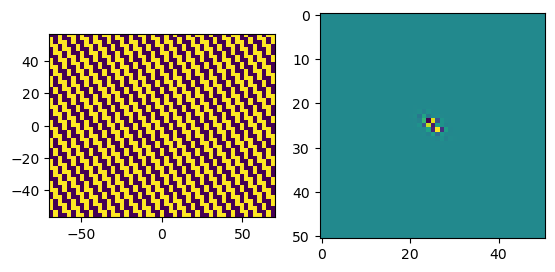

In [50]:
idx_phase, idx_angle, idx_cycle = 0, 3, 9
print(
    f"phase={hbm.measure_points[0][idx_phase]} angle={hbm.measure_points[1][idx_angle]} cycle={hbm.measure_points[2][idx_cycle]}"
)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(
    hbm.gratings[idx_phase, idx_angle, idx_cycle, ...],
    extent=[hbm.X_FoV.min(), hbm.X_FoV.max(), hbm.Y_FoV.min(), hbm.Y_FoV.max()],
    origin="lower",
)

ax = fig.add_subplot(122)
ax.imshow(hbm.model_of_gabor_filter(params))
params

In [63]:
5000 / 80

62.5

In [8]:
import pickle

# with open('inference_result.pkl','wb') as f_open:
# pickle.dump(sampler,f_open)
with open("inference_result.pkl", "rb") as f_open:
    sampler = pickle.load(f_open)

amplitude mean: 2.4047010737930434
sigma_x mean: 1.0430003465429227
sigma_y mean: 1.730688754329086
gamma mean: 0.38228850310336154
f mean: 0.272680959578316
theta mean: 2.5054348904504837
phi_0 mean: 3.1546647628363482
theta_gauss mean: 0.01141337586623926


In [54]:
hist = np.histogramdd(sampler.results.samples[:, [-3, -1]], bins=21, weights=weights)
X, Y = np.meshgrid(*hist[1])

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (17, 9) and arg 2 with shape (21, 21).

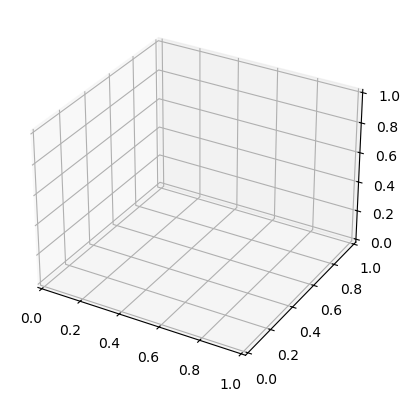

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X[:-1, :-1], Y[:-1, :-1], hist[0])

In [40]:
51**8 * 32 / (1024 * 1024 * 1024)

1363991.0391092598

In [119]:
my_prior_trafo = hbm.set_prior_transform(vectorized=False)
my_logp = hbm.set_logp_func(vectorized=False)

# p = np.random.rand(8)
# p_transformed = my_prior_trafo(p)
p_transformed = list(mean.values())
print(p_transformed)
params = hbm.from_p_to_params(p_transformed)
my_logp(p_transformed)
params

[0.3919226003836449, 1.4610248711443783, 1.2027978652558888, 2.4619901601163017, 0.16515089626909446, 1.5954212280672058, 3.1207012708588193, 1.5712554868213928]


TypeError: list indices must be integers or slices, not tuple

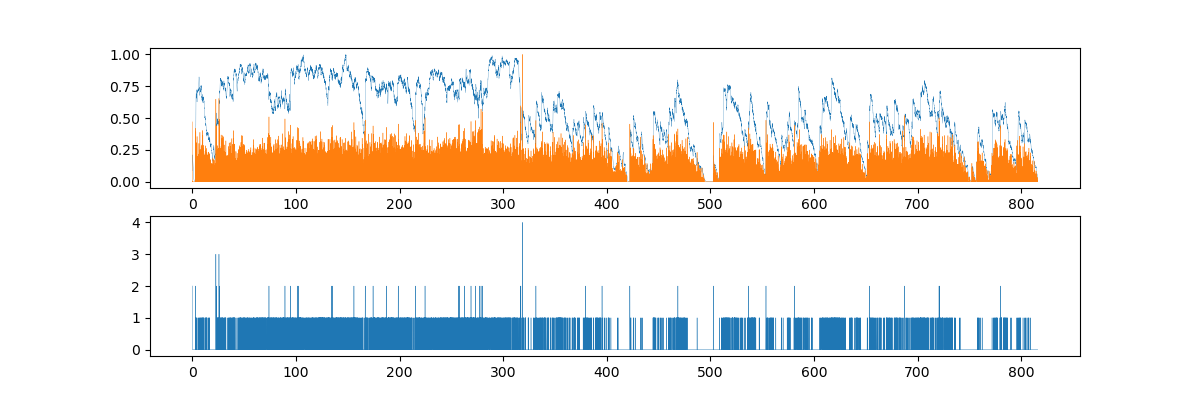

In [19]:
n = 0
# res = get_firingrate(caiman_data["S"][n,:],f=30.05,sd_r=1,Ns_thr=10)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(211)
ax.plot(
    data["frame_times"],
    caiman_data["C"][n, :] / caiman_data["C"][n, :].max(),
    linewidth=0.2,
)
ax.plot(
    data["frame_times"],
    caiman_data["S"][n, :] / caiman_data["S"][n, :].max(),
    linewidth=0.3,
)

ax = fig.add_subplot(212)
ax.plot(data["frame_times"], spikes[n, :], linewidth=0.3)

In [138]:
arrays

{'angles': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170], dtype=uint8),
 'cycles': array([0.0079    , 0.01099588, 0.01530497, 0.02130273, 0.0296509 ,
        0.04127058, 0.05744382, 0.07995507, 0.1112881 , 0.1549    ]),
 'phases': array([120, 240, 360], dtype=uint16)}

In [70]:
X, Y = np.meshgrid(arrays["cycles"], arrays["angles"])
pos = np.dstack((X, Y))

stimulus_steps = 51
X_stimulus, Y_stimulus = np.meshgrid(
    np.linspace(-100, 100, stimulus_steps), np.linspace(-100, 100, stimulus_steps)
)

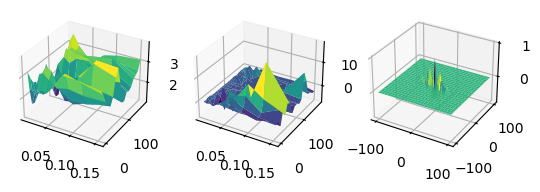

In [73]:
neuron = 14

phase_idx = 2
# fmap = gauss_smooth(firing_maps[..., neuron].max(axis=0), (1, 1), mode="wrap")
fmap = gauss_smooth(firing_maps[phase_idx, ..., neuron], (1, 1), mode="wrap")
fig = plt.figure()
ax_empirical = fig.add_subplot(131, projection="3d")
ax_empirical.plot_surface(X, Y, fmap, cmap="viridis")


ax_model = fig.add_subplot(133, projection="3d")
model = gabor_filter(
    X_stimulus,
    Y_stimulus,
    A=1.0,
    sigma_x=4.0,
    sigma_y=10.0,
    gamma=0.5,
    f=0.12,
    theta=50.0 / 180 * np.pi,
    phi_0=0,
    theta_gauss=20.0 / 180 * np.pi,
)
ax_model.plot_surface(X_stimulus, Y_stimulus, model, cmap="viridis")

ax_model_response = fig.add_subplot(132, projection="3d")

fmap_model_at_phase = np.zeros((3, steps["angles"], steps["cycles"]))
for prod in itertools.product(enumerate(arrays["angles"]), enumerate(arrays["cycles"])):

    idx, elems = zip(*prod)
    theta, f = elems

    response_at_phi = np.zeros(steps["phases"])
    for i, phi_ in enumerate(arrays["phases"]):
        grating_ = sine_grating(
            X_stimulus,
            Y_stimulus,
            theta * np.pi / 180,
            f,
            phi_ * np.pi / 180,
            square=True,
        )
        response_at_phi[i] = (model * grating_).sum()

    for i in range(3):
        # print(i,i * (steps["phi_0"] // 3), arrays['phi_0'][i * (steps["phi_0"] // 3)])
        fmap_model_at_phase[i, idx[0], idx[1]] = response_at_phi[
            i * (steps["phases"] // 3)
        ]

ax_model_response.plot_surface(
    X, Y, fmap_model_at_phase[phase_idx, ...], cmap="viridis"
)

In [187]:
def probability_of_spike_observation(fmap, dwelltime, fmap_model):
    ## get probability to observe N spikes (amplitude) within dwelltime for each bin in each trial

    log_fmap_factorial = np.log(sp_factorial(fmap))
    # print(log_fmap_factorial)
    logp = fmap * np.log(fmap_model * dwelltime) - log_fmap_factorial - fmap * dwelltime

    # logp[np.logical_and(fmap == 0, fmap == 0)] = 0
    logp[np.isnan(logp)] = -1000.0
    # logp[np.isinf(logp)] = -100.0  # np.finfo(logp.dtype).min
    return logp

In [192]:
fmap = gauss_smooth(firing_maps[..., neuron], (0, 1, 1), mode="wrap")
logp = probability_of_spike_observation(
    fmap, dwelltime[..., neuron], fmap_model_at_phase
)
## why positive?
## get proper dwelltime
## should transfer S to spikes first? (thresholding)

logp.sum()

-381507.76984926825

In [81]:
stimulus_steps = 101
X_stimulus, Y_stimulus = np.meshgrid(
    np.linspace(-100, 100, stimulus_steps), np.linspace(-100, 100, stimulus_steps)
)

G = gabor_filter(
    X_stimulus,
    Y_stimulus,
    A=1.0,
    sigma_x=4.0,
    sigma_y=10.0,
    gamma=0.5,
    f=0.12,
    theta=50.0 / 180 * np.pi,
    phi_0=0,
    theta_gauss=20.0 / 180 * np.pi,
)

gratings = np.zeros(
    (steps["phases"], steps["angles"], steps["cycles"], stimulus_steps, stimulus_steps)
)
responses = np.zeros((steps["phases"], steps["angles"], steps["cycles"]))
for prod in itertools.product(
    enumerate(arrays["phases"]),
    enumerate(arrays["angles"]),
    enumerate(arrays["cycles"]),
):
    idx, elems = zip(*prod)
    phi_0, theta, f = elems

    gratings[*idx, ...] = sine_grating(
        X_stimulus, Y_stimulus, theta * np.pi / 180, f, phi_0 * np.pi / 180, square=True
    )

In [246]:
phase_grid, angle_grid, cycle_grid = np.meshgrid(
    arrays["phases"], arrays["angles"], arrays["cycles"]
)
cycle_grid[:, 0, :].shape

(18, 10)

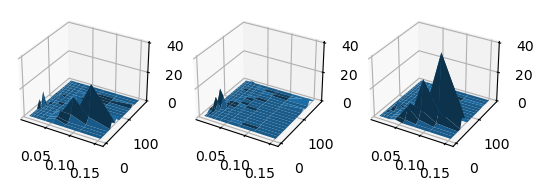

In [69]:
def get_responses(
    gratings,
    X_stimulus,
    Y_stimulus,
    A=1.0,
    sigma_x=4.0,
    sigma_y=10.0,
    gamma=0.5,
    f=0.12,
    theta=50.0 / 180 * np.pi,
    phi_0=70.0,
    theta_gauss=20.0 / 180 * np.pi,
):

    G = gabor_filter(
        X_stimulus,
        Y_stimulus,
        A=A,
        sigma_x=sigma_x,
        sigma_y=sigma_y,
        gamma=gamma,
        f=f,
        theta=theta,
        phi_0=phi_0,
        theta_gauss=theta_gauss,
    )
    responses = (G * gratings).sum(axis=(-2, -1))
    return responses


responses = get_responses(gratings, X_stimulus, Y_stimulus)

fig = plt.figure()
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot_surface(X, Y, np.maximum(1, responses[0, ...]))
ax2 = fig.add_subplot(132, projection="3d")
ax2.plot_surface(X, Y, np.maximum(1, responses[1, ...]))
ax3 = fig.add_subplot(133, projection="3d")
ax3.plot_surface(X, Y, np.maximum(1, responses[2, ...]))

for axx in [ax1, ax2, ax3]:
    plt.setp(axx, zlim=[0, 40])
# gratings.shape

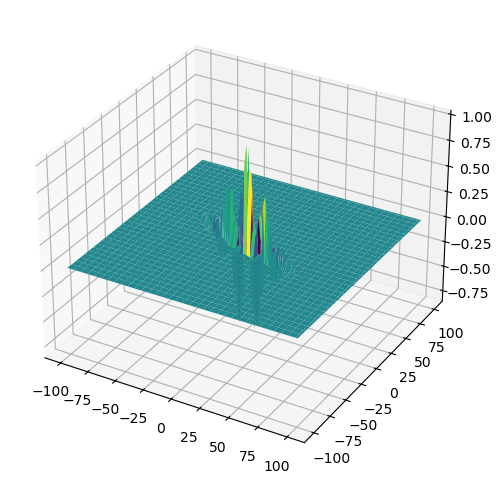

In [82]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111, projection="3d")
ax1.plot_surface(X_stimulus, Y_stimulus, G, cmap="viridis")
# ax2 = fig.add_subplot(132, projection="3d")
# ax2.plot_surface(X, Y, np.maximum(1, responses[1, ...]))
# ax3 = fig.add_subplot(133, projection="3d")
# ax3.plot_surface(X, Y, np.maximum(1, responses[2, ...]))

In [75]:
%timeit (G * gratings).sum(axis=(-2,-1))

1.21 ms ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [76]:
%timeit np.tensordot(G,gratings,axes=([0,1],[3,4]))

205 µs ± 3.55 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [51]:
def covariance_matrix(standard_deviation, theta):
    # Covariance matrix
    # print(theta)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    Lambda = np.diag(standard_deviation**2)
    # print(f"{R=}, {Lambda=}")
    return R @ Lambda @ R.T


# Gaussian function
def multivariate_gaussian(pos, mu, Sigma):
    # n = mu.shape[0]
    print(Sigma)
    # print(pos.shape,mu.shape)
    diff = pos - mu
    # print(diff)
    inv_Sigma = np.linalg.inv(Sigma)
    det_Sigma = np.linalg.det(Sigma)
    # print(inv_Sigma, det_Sigma)
    norm_const = 1.0 / (2 * np.pi * np.sqrt(det_Sigma))
    result = np.einsum("...i,ij,...j->...", diff, inv_Sigma, diff)
    return norm_const * np.exp(-0.5 * result)


def orientation_model(pos, A, mean_x, mean_y, sigma_x, sigma_y, theta):
	## adjust all values for radians
	theta *= np.pi / 180.0
	mean_x *= np.pi / 180.0
	sigma_x *= np.pi / 180.0
	pos[...,0] *= np.pi / 180.0

	mu = np.array([mean_x, mean_y])
	standard_deviation = np.array([sigma_x, sigma_y])

	Sigma = covariance_matrix(standard_deviation, theta)	Z = A * multivariate_gaussian(pos, mu, Sigma)

	return Z

[[0.01648087 0.01398087]
 [0.01398087 0.01648087]]


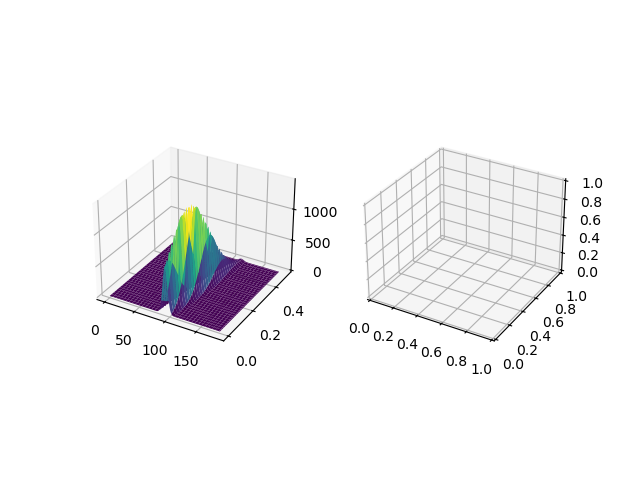

In [76]:
n = 8
# theta = data['angle']
# theta = np.linspace(0,np.pi,21)
# cycles = data['CPD']
theta = np.linspace(0, 180.0, 101)
cycles = np.linspace(0, 0.5, 101)
X, Y = np.meshgrid(theta, cycles)
pos = np.dstack((X, Y))


fig = plt.figure()
ax = fig.add_subplot(121, projection="3d")
model = orientation_model(pos, 80.0, 100.0, 0.15, 10.0, 0.05, 45.0)

ax.plot_surface(X, Y, model, cmap="viridis")

ax = fig.add_subplot(122, projection="3d")
# ax.plot_surface(X, Y, gauss_smooth(firing_maps[2,...,n],(1,1)).T, cmap='viridis')

# logp = probability_of_spike_observation(firing_maps[2,...,n].T, dwelltime[2,...,n].T, model)
# logp

# for some reason, ellipse is not properly created (inverse not well defined?)
# anyway, maybe rather fit gabor filter to data?
# 	however, requires to calculate response for each combination theta,cycle (including gratings, ...)
# 	define function to get that - how to make it not that costly? precalculate all gratings? vectorized multiplication?

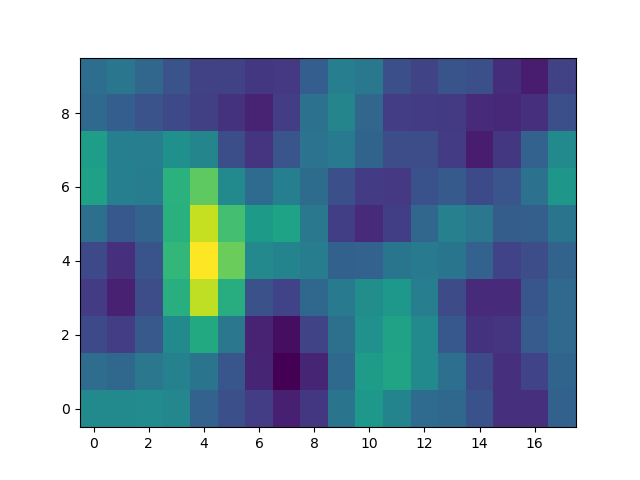

In [72]:
n = 8

fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(
    gauss_smooth(firing_maps[2, ..., n], (1, 1)).T,
    origin="lower",
    aspect="auto",
    cmap="viridis",
)